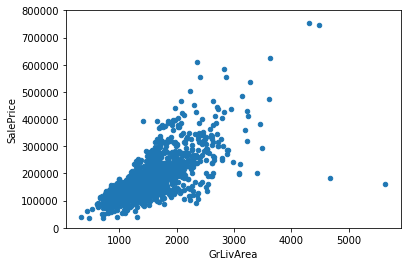

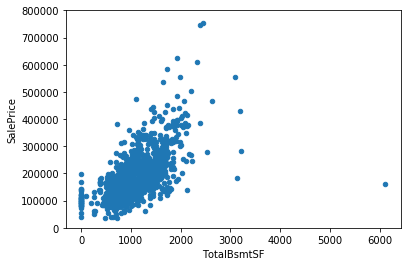

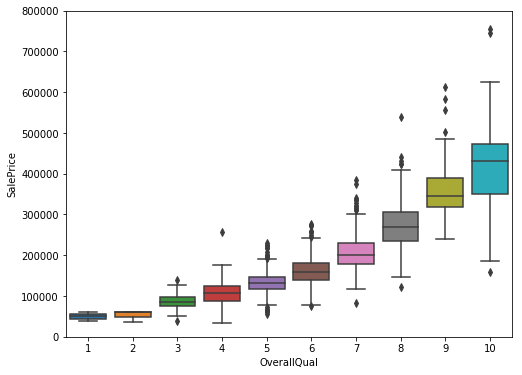

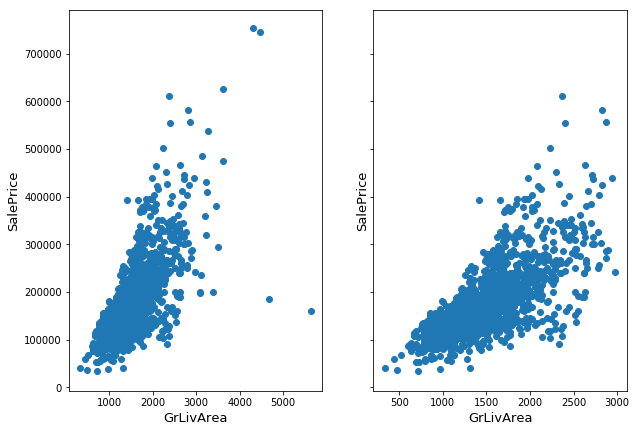

In [24]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
from scipy import stats
#For some Statistics
from scipy.stats import norm, skew
from sklearn.preprocessing import Imputer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df = pd.read_csv('./data/train.csv',index_col=0)
df.head()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lm = LinearRegression()
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=101)

## Linear Regression does not work at this point due to
## could not convert string to float: 'RL'
## hence work on cleaning/pre processing.

#Scatter plot GrLivArea vs SalePrice , checking for outliers.
data = pd.concat([df['SalePrice'], df['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

#Scatter plot TotalBsmtSF vs SalePrice , checking for outliers.

data = pd.concat([df['SalePrice'], df['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0, 800000));

# Box plot of OverallQual vs SalePrice
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice",data=df[['SalePrice','OverallQual']])
fig.axis(ymin=0, ymax=800000)


#Deleting outliers
data = df.copy()
df = df.drop(df[(df['GrLivArea']>3000) & \
                (df['GrLivArea']<6000)].index)

f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 7))

ax1.scatter(data['GrLivArea'], data['SalePrice']);
ax1.set_ylabel('SalePrice', fontsize=13)
ax1.set_xlabel('GrLivArea', fontsize=13)

ax2.scatter(df['GrLivArea'], df['SalePrice'])
ax2.set_ylabel('SalePrice', fontsize=13)
ax2.set_xlabel('GrLivArea', fontsize=13)

plt.show()


## Remove Missing Values

In [31]:
df.isnull().sum(axis=1).sort_values(ascending=False).head()
len(df.columns)
# missing data
total = df.isnull().sum(axis=1).sort_values(ascending=False)

percent = total/len(df.columns)
missing_data = pd.concat([total, percent*100], axis=1, \
                         keys=['Total_missing_values_per_row', 'Percent'])
missing_data.head(20)
len(missing_data['Total_missing_values_per_row'])
# All rows have missing data! cannot use below method
df_copy = df.copy().dropna(how='any')
df_copy.shape

###  df_copy = df.copy().dropna(how='all')
###  df.shape
###  can use above which will drop rows having all null values.

#missing data observing in columns
total = df.isnull().sum(axis=0).sort_values(ascending=False)
percent = (100*total)/len(df)

# count the number of null values in the column and their perecentage of the total data
missing_data_columns = pd.concat([total, percent], axis=1, \
                                 keys=['Total', 'Percent'])
missing_data_columns.head(20)

# Look at null values
#print(df[["PoolQC","MiscFeature","GarageYrBlt","GarageArea","GarageCars"]])

# Solution for null values
df2=df.copy()
df2["PoolQC"] = df2["PoolQC"].fillna("None")
df2["MiscFeature"] = df2["MiscFeature"].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df2[col] = df2[col].fillna(0)

# Imputation Using Imputer
#Mean value imputation for 'LotFrontage' column (numerical feature).
imp_mean = Imputer(missing_values = 'NaN', strategy='mean')
imp_mean.fit(df2[['LotFrontage']])
df2['LotFrontage'] = imp_mean.transform(df[['LotFrontage']])
#print(df2["LotFrontage"])

#Mode value imputation for the 'MSZoning' column (categorical feature).
df2['MSZoning'] = df2['MSZoning'].fillna(df2['MSZoning'].mode()[0])
#rint(df2['MSZoning'])

# Create new features by combining the existing features
# Overall pool score obtained by multiplying PoolArea and PoolQuality
df["PoolScore"] = df["PoolArea"] * df["PoolQC"]
# Total number of bathrooms obtained by adding all the bathrooms in the house and multiplying it by 0.5 if they are half the size of an actual bathroom
df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + df["FullBath"] + (0.5 * df["HalfBath"])


#Seperating the data into categorical and numerical data.
numeric_feature = [a for a in range(len(df.dtypes)) if df.dtypes[a] in ['int64','float64']]
numeric_data = df.iloc[:,numeric_feature]

cat_name = df.columns.difference(df.columns[numeric_feature])
cat_data = df.loc[:,cat_name]

numeric_data.head()
cat_data.head()

numeric_data.isnull().values.any() #returns True as there are null values.
#Replace nan with median values for numeric features.

from sklearn.preprocessing import Imputer

fill_Nan = Imputer(missing_values=np.nan, strategy='median', axis=1)
imputed_DF = pd.DataFrame(fill_Nan.fit_transform(numeric_data))
imputed_DF.columns = numeric_data.columns
imputed_DF.index = numeric_data.index
imputed_DF.info()
imputed_DF.isnull().values.any()
## now returns False as there are no Null values.
## next step is scaling..

# Standardizing numerical features
from sklearn.preprocessing import StandardScaler

stand_scale= StandardScaler()
imputed_DF = pd.DataFrame(stand_scale.fit_transform(imputed_DF))
imputed_DF.columns = numeric_data.columns
imputed_DF.index = numeric_data.index

imputed_DF.head()

## Categorical columns encoding.
from sklearn.preprocessing import LabelEncoder

#Labelencodes any dataframe column of type category or object.

def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df
dummyEncode(cat_data)


Id
534     16
1219    16
1012    16
40      16
521     15
dtype: int64

82

,Total_missing_values_per_row,Percent
Id,,
534,16,19.512195
1219,16,19.512195
1012,16,19.512195
40,16,19.512195
521,15,18.292683
1180,15,18.292683
706,15,18.292683
343,12,14.634146
1031,12,14.634146


1442

(0, 82)

,Total,Percent
PoolQC,1438,99.722607
PoolScore,1438,99.722607
MiscFeature,1388,96.255201
Alley,1352,93.758669
Fence,1166,80.859917
FireplaceQu,689,47.780860
LotFrontage,257,17.822469
GarageQual,79,5.478502
GarageCond,79,5.478502
GarageType,79,5.478502


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,TotalBath
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,61,0,0,0,0,0,2,2008,208500,3.5
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,0,0,5,2007,181500,2.5
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,42,0,0,0,0,0,9,2008,223500,3.5
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,35,272,0,0,0,0,2,2006,140000,2.0
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,84,0,0,0,0,0,12,2008,250000,3.5


,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,...,Neighborhood,PavedDrive,PoolQC,PoolScore,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
Id,,,,,,,,,,,,,,,,,,,,,
1,NaN,1Fam,TA,No,GLQ,Unf,Gd,Y,Norm,Norm,...,CollgCr,Y,NaN,NaN,CompShg,Gable,Normal,WD,Pave,AllPub
2,NaN,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,...,Veenker,Y,NaN,NaN,CompShg,Gable,Normal,WD,Pave,AllPub
3,NaN,1Fam,TA,Mn,GLQ,Unf,Gd,Y,Norm,Norm,...,CollgCr,Y,NaN,NaN,CompShg,Gable,Normal,WD,Pave,AllPub
4,NaN,1Fam,Gd,No,ALQ,Unf,TA,Y,Norm,Norm,...,Crawfor,Y,NaN,NaN,CompShg,Gable,Abnorml,WD,Pave,AllPub
5,NaN,1Fam,TA,Av,GLQ,Unf,Gd,Y,Norm,Norm,...,NoRidge,Y,NaN,NaN,CompShg,Gable,Normal,WD,Pave,AllPub


True

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442 entries, 1 to 1460
Data columns (total 38 columns):
MSSubClass       1442 non-null float64
LotFrontage      1442 non-null float64
LotArea          1442 non-null float64
OverallQual      1442 non-null float64
OverallCond      1442 non-null float64
YearBuilt        1442 non-null float64
YearRemodAdd     1442 non-null float64
MasVnrArea       1442 non-null float64
BsmtFinSF1       1442 non-null float64
BsmtFinSF2       1442 non-null float64
BsmtUnfSF        1442 non-null float64
TotalBsmtSF      1442 non-null float64
1stFlrSF         1442 non-null float64
2ndFlrSF         1442 non-null float64
LowQualFinSF     1442 non-null float64
GrLivArea        1442 non-null float64
BsmtFullBath     1442 non-null float64
BsmtHalfBath     1442 non-null float64
FullBath         1442 non-null float64
HalfBath         1442 non-null float64
BedroomAbvGr     1442 non-null float64
KitchenAbvGr     1442 non-null float64
TotRmsAbvGrd     1442 non-null floa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


False

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,TotalBath
Id,,,,,,,,,,,,,,,,,,,,,
1,0.076255,0.219464,-0.194541,0.682599,-0.518955,1.054794,0.882718,0.560648,0.632594,-0.288541,...,0.228068,-0.364331,-0.117073,-0.270177,-0.052286,-0.088238,-1.604317,0.137899,0.409612,1.698221
2,-0.867602,0.684630,-0.077150,-0.053057,2.198961,0.154234,-0.421313,-0.580768,1.267655,-0.288541,...,-0.706060,-0.364331,-0.117073,-0.270177,-0.052286,-0.088238,-0.494228,-0.615323,0.043058,0.398760
3,0.076255,0.312498,0.091280,0.682599,-0.518955,0.988086,0.834421,0.362647,0.118941,-0.288541,...,-0.062890,-0.364331,-0.117073,-0.270177,-0.052286,-0.088238,0.985890,0.137899,0.613253,1.698221
4,0.312219,0.064409,-0.082254,0.682599,-0.518955,-1.880365,-0.711098,-0.580768,-0.511451,-0.288541,...,-0.170085,4.214305,-0.117073,-0.270177,-0.052286,-0.088238,-1.604317,-1.368546,-0.520350,-0.250971
5,0.076255,0.808674,0.398537,1.418255,-0.518955,0.954732,0.737826,1.457474,0.513520,-0.288541,...,0.580281,-0.364331,-0.117073,-0.270177,-0.052286,-0.088238,2.095979,0.137899,0.973019,1.698221


Error encoding Alley
Error encoding BsmtCond
Error encoding BsmtExposure
Error encoding BsmtFinType1
Error encoding BsmtFinType2
Error encoding BsmtQual
Error encoding Electrical
Error encoding Fence
Error encoding FireplaceQu
Error encoding GarageCond
Error encoding GarageFinish
Error encoding GarageQual
Error encoding GarageType
Error encoding MasVnrType
Error encoding MiscFeature
Error encoding PoolQC
Error encoding PoolScore


,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,...,Neighborhood,PavedDrive,PoolQC,PoolScore,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
Id,,,,,,,,,,,,,,,,,,,,,
1,NaN,0,TA,No,GLQ,Unf,Gd,1,2,2,...,5,2,NaN,NaN,0,1,4,8,1,0
2,NaN,0,TA,Gd,ALQ,Unf,Gd,1,1,2,...,24,2,NaN,NaN,0,1,4,8,1,0
3,NaN,0,TA,Mn,GLQ,Unf,Gd,1,2,2,...,5,2,NaN,NaN,0,1,4,8,1,0
4,NaN,0,Gd,No,ALQ,Unf,TA,1,2,2,...,6,2,NaN,NaN,0,1,0,8,1,0
5,NaN,0,TA,Av,GLQ,Unf,Gd,1,2,2,...,15,2,NaN,NaN,0,1,4,8,1,0
6,NaN,0,TA,No,GLQ,Unf,Gd,1,2,2,...,11,2,NaN,NaN,0,1,4,8,1,0
7,NaN,0,TA,Av,GLQ,Unf,Ex,1,2,2,...,21,2,NaN,NaN,0,1,4,8,1,0
8,NaN,0,TA,Mn,ALQ,BLQ,Gd,1,4,2,...,14,2,NaN,NaN,0,1,4,8,1,0
9,NaN,0,TA,No,Unf,Unf,TA,1,0,2,...,17,2,NaN,NaN,0,1,0,8,1,0


## Linear Regression Fitting 

In [6]:

lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
print(lm.intercept_)
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df
plt.scatter(y_test,predictions)
sns.distplot((y_test-predictions),bins=50);
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


ValueError: could not convert string to float: 'RL'